# Add bench to valid

In [8]:
import scanpy as sc
from scprint import scPrint
from scdataloader import Preprocessor
from scprint.tasks import GRNfer
import umap

from grnndata import GRNAnnData, read_h5ad, from_anndata
from grnndata import utils 
from bengrn import BenGRN, get_sroy_gt


import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from collections import Counter

from bengrn.base import get_GT_db

from scprint.utils import utils

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.model_selection import train_test_split

from scib_metrics.benchmark import Benchmarker

from scprint.tasks import Embedder
from bengrn import compute_genie3, compute_scenic

from joblib import dump, load
from bengrn.base import compute_auprc
from grnndata import utils as grnutils

%load_ext autoreload
%autoreload 2

import torch
torch.set_float32_matmul_precision('medium')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

  %reload_ext autoreload


In [3]:
#model = scPrint.load_from_checkpoint('../../data/tensorboard/scprint_test/urxxwu28/checkpoints/epoch=0-step=20000.ckpt') #chocolate-surf-8
model = scPrint.load_from_checkpoint('../../data/temp/za9mg1w3/epoch=7-step=40000.ckpt', precpt_gene_emb = '../../data/main/gene_embeddings.parquet')
# ../../data/temp/epoch=4-step=12500.ckpt latest model maestro (fortuitous laugther)
# ../../data/logs/scprint_test/f4vao230/checkpoints/epoch=10-step=27500.ckpt looked good as a training run (vermlillion noodle)
# d1792z9k/epoch=3-step=10000.ckpt
# '../../data/temp/d1792z9k/epoch=3-step=10000.ckpt'
# '../../data/temp/6q3dzi3x/epoch=3-step=10000.ckpt'
# '../../data/temp/grsachbg/epoch=2-step=15000.ckpt'
## post debug
# "../lightning_logs/version_14/checkpoints/epoch=1-step=5000.ckpt"

In [4]:
adata = sc.read(
    "data/pancreas_atlas.h5ad",
    backup_url="https://figshare.com/ndownloader/files/24539828",
)

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/specs/registry.py:249: OldFormatWarning: Element '/X' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/specs/registry.py:249: OldFormatWarning: Element '/layers' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/specs/registry.py:249: OldFormatWarning: Element '/layers/counts' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/ml4ig1/miniconda3/

In [5]:
preprocessor = Preprocessor(use_layer='counts', is_symbol=True, force_preprocess=True, skip_validate=True, do_postp=False)

In [7]:
adata.obs['organism_ontology_term_id'] = "NCBITaxon:9606"
adata = preprocessor(adata.copy())
adata.obs

X was not raw counts, using 'counts' layer
Dropping layers:  KeysView(Layers with keys: counts)
checking raw counts
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 16382 renamining
filtered out 0 cells, 16382 renamining
Removed 0 genes.
startin QC
Seeing 4678 outliers (28.56% of total dataset):
done


tech celltype  size_factors  \
c00431e9-f4f5-42d2-9ac0-75f210848c3d   celseq    gamma      0.028492   
a1cfb18b-77bd-458d-8a0a-0dae61b723ed   celseq    gamma      0.079348   
20f89974-bdce-49d8-b3d9-9cf2cad9fcc3   celseq    gamma      0.037932   
ee8507f0-e1ba-45af-806a-f614150d4ee8   celseq    gamma      0.047685   
f7162b99-df73-48ab-af1f-ae08837abe35   celseq    gamma      0.038683   
...                                       ...      ...           ...   
19461965-ed83-481c-87b8-cfc2a871157c  smarter    gamma      1.000000   
e17262e8-4f65-4fbf-85fb-6fe8b3549763  smarter    gamma      1.000000   
22ba2273-0825-4d16-9772-cb31a7c96630  smarter    gamma      1.000000   
3bbd6219-11df-4978-a7dc-760297405bc2  smarter    gamma      1.000000   
668811ef-4340-49f2-beaa-85e0285ae67f  smarter    gamma      1.000000   

                                     organism_ontology_term_id   nnz  \
c00431e9-f4f5-42d2-9ac0-75f210848c3d            NCBITaxon:9606  1857   
a1cfb18b-77bd-458d-8a0a-0dae61b723ed            NCBITaxon:9606  1857   
20f89974-bdce-49d8-b3d9-9cf2cad9fcc3            NCBITaxon:9606  1857   
ee8507f0-e1ba-45af-806a-f614150d4ee8            NCBITaxon:9606  1857   
f7162b99-df73-48ab-af1f-ae08837abe35            NCBITaxon:9606  1857   
...                                                        ...   ...   
19461965-ed83-481c-87b8-cfc2a871157c            NCBITaxon:9606  1857   
e17262e8-4f65-4fbf-85fb-6fe8b3549763            NCBITaxon:9606  1857   
22ba2273-0825-4d16-9772-cb31a7c96630            NCBITaxon:9606  1857   
3bbd6219-11df-4978-a7dc-760297405bc2            NCBITaxon:9606  1857   
668811ef-4340-49f2-beaa-85e0285ae67f            NCBITaxon:9606  1857   

                                      n_genes_by_counts  \
c00431e9-f4f5-42d2-9ac0-75f210848c3d               1767   
a1cfb18b-77bd-458d-8a0a-0dae61b723ed               3537   
20f89974-bdce-49d8-b3d9-9cf2cad9fcc3               2145   
ee8507f0-e1ba-45af-806a-f614150d4ee8               2501   
f7162b99-df73-48ab-af1f-ae08837abe35               2127   
...                                                 ...   
19461965-ed83-481c-87b8-cfc2a871157c               5517   
e17262e8-4f65-4fbf-85fb-6fe8b3549763               4923   
22ba2273-0825-4d16-9772-cb31a7c96630               6010   
3bbd6219-11df-4978-a7dc-760297405bc2               3932   
668811ef-4340-49f2-beaa-85e0285ae67f               3789   

                                      log1p_n_genes_by_counts   total_counts  \
c00431e9-f4f5-42d2-9ac0-75f210848c3d                 7.477604    3921.636230   
a1cfb18b-77bd-458d-8a0a-0dae61b723ed                 8.171317   10230.473633   
20f89974-bdce-49d8-b3d9-9cf2cad9fcc3                 7.671361    4730.720703   
ee8507f0-e1ba-45af-806a-f614150d4ee8                 7.824846    5925.488281   
f7162b99-df73-48ab-af1f-ae08837abe35                 7.662938    4619.637695   
...                                                       ...            ...   
19461965-ed83-481c-87b8-cfc2a871157c                 8.615771  479020.937500   
e17262e8-4f65-4fbf-85fb-6fe8b3549763                 8.501876  314639.093750   
22ba2273-0825-4d16-9772-cb31a7c96630                 8.701346  403987.875000   
3bbd6219-11df-4978-a7dc-760297405bc2                 8.277158  393747.062500   
668811ef-4340-49f2-beaa-85e0285ae67f                 8.240121  443699.187500   

                                      log1p_total_counts  \
c00431e9-f4f5-42d2-9ac0-75f210848c3d            8.274519   
a1cfb18b-77bd-458d-8a0a-0dae61b723ed            9.233224   
20f89974-bdce-49d8-b3d9-9cf2cad9fcc3            8.462044   
ee8507f0-e1ba-45af-806a-f614150d4ee8            8.687187   
f7162b99-df73-48ab-af1f-ae08837abe35            8.438288   
...                                                  ...   
19461965-ed83-481c-87b8-cfc2a871157c           13.079502   
e17262e8-4f65-4fbf-85fb-6fe8b3549763           12.659184   
22ba2273-0825-4d16-9772-cb31a7c96630           12.909142   
3bbd6219-11df-4978-a7dc-760297405bc2     

In [9]:
embedder = Embedder(model, pred_embedding=['cell_type_ontology_term_id'])#), 'sex_ontology_term_id', "disease_ontology_term_id"])

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

AnnData object with n_obs × n_vars = 16382 × 512
    obs: 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id', 'sprint_leiden'
    uns: 'neighbors', 'umap', 'leiden'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in panda

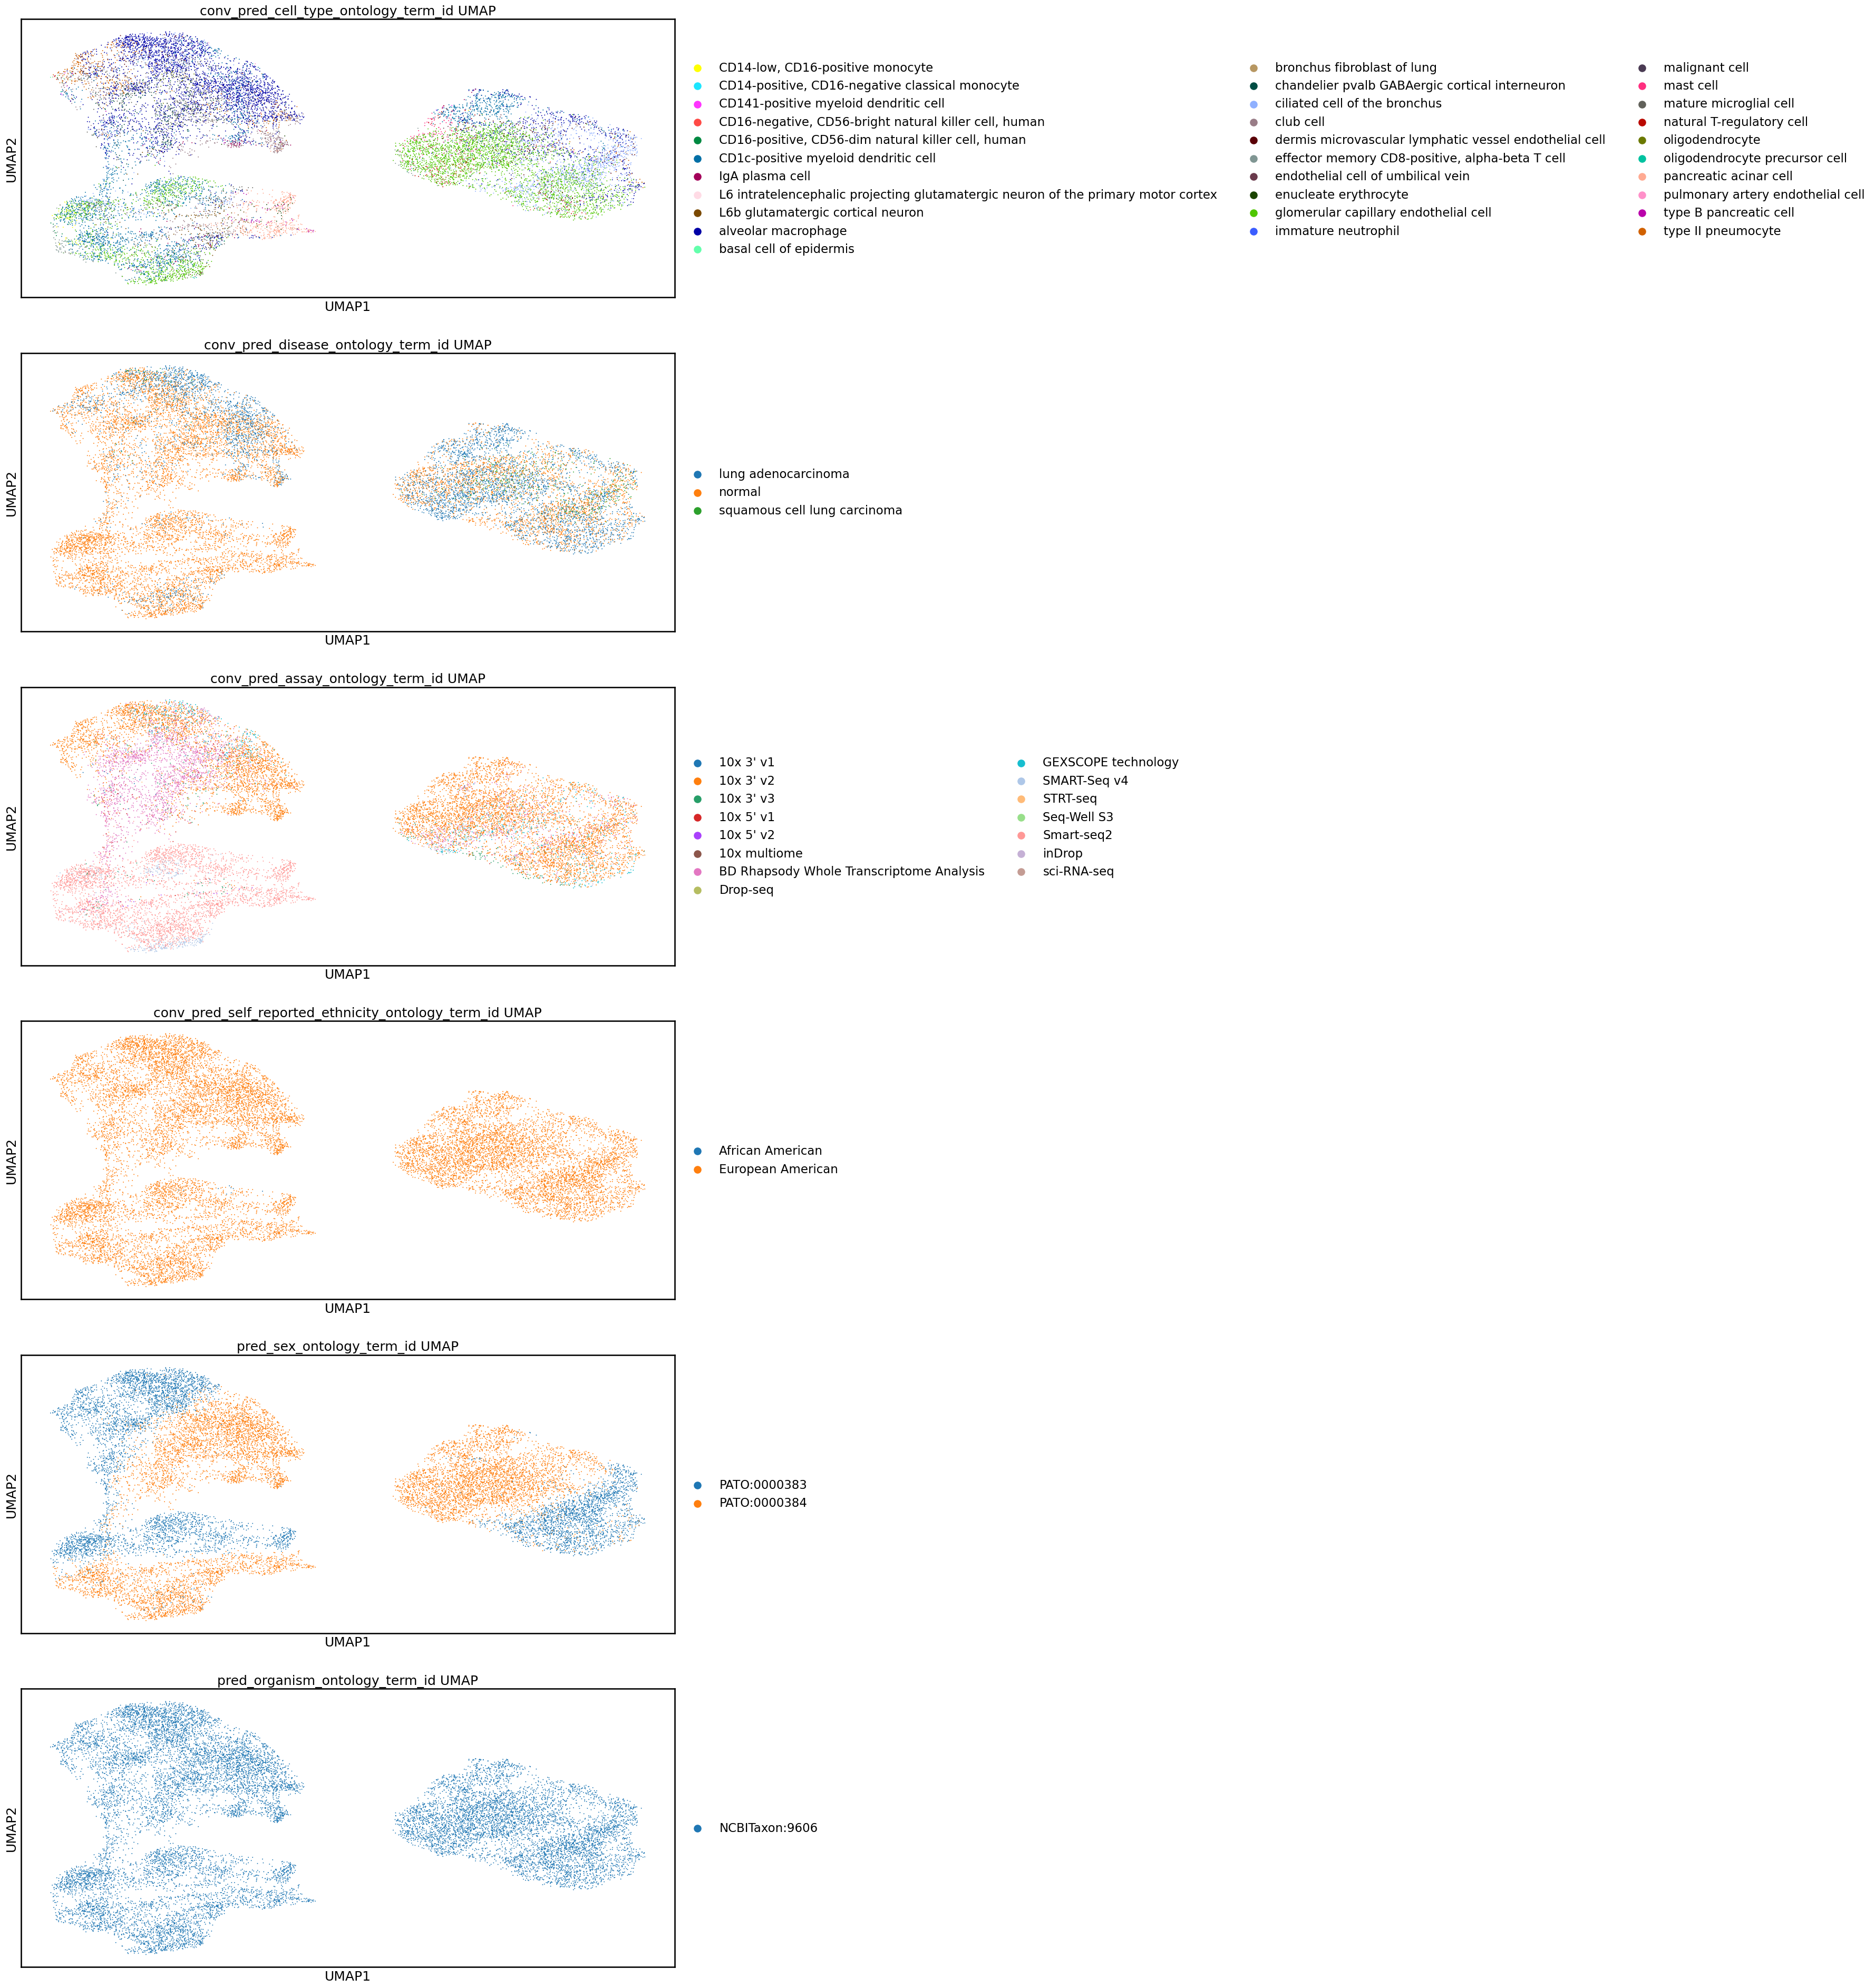

couldn't log to tensorboard
couldn't log to wandb
metrics for this dataset of size: 16382
     organism_ontology_term_id
     accuracy: 1.0
 


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

AnnData object with n_obs × n_vars = 64 × 512
    obs: 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id', 'sprint_leiden'
    uns: 'neighbors', 'umap', 'leiden'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in panda

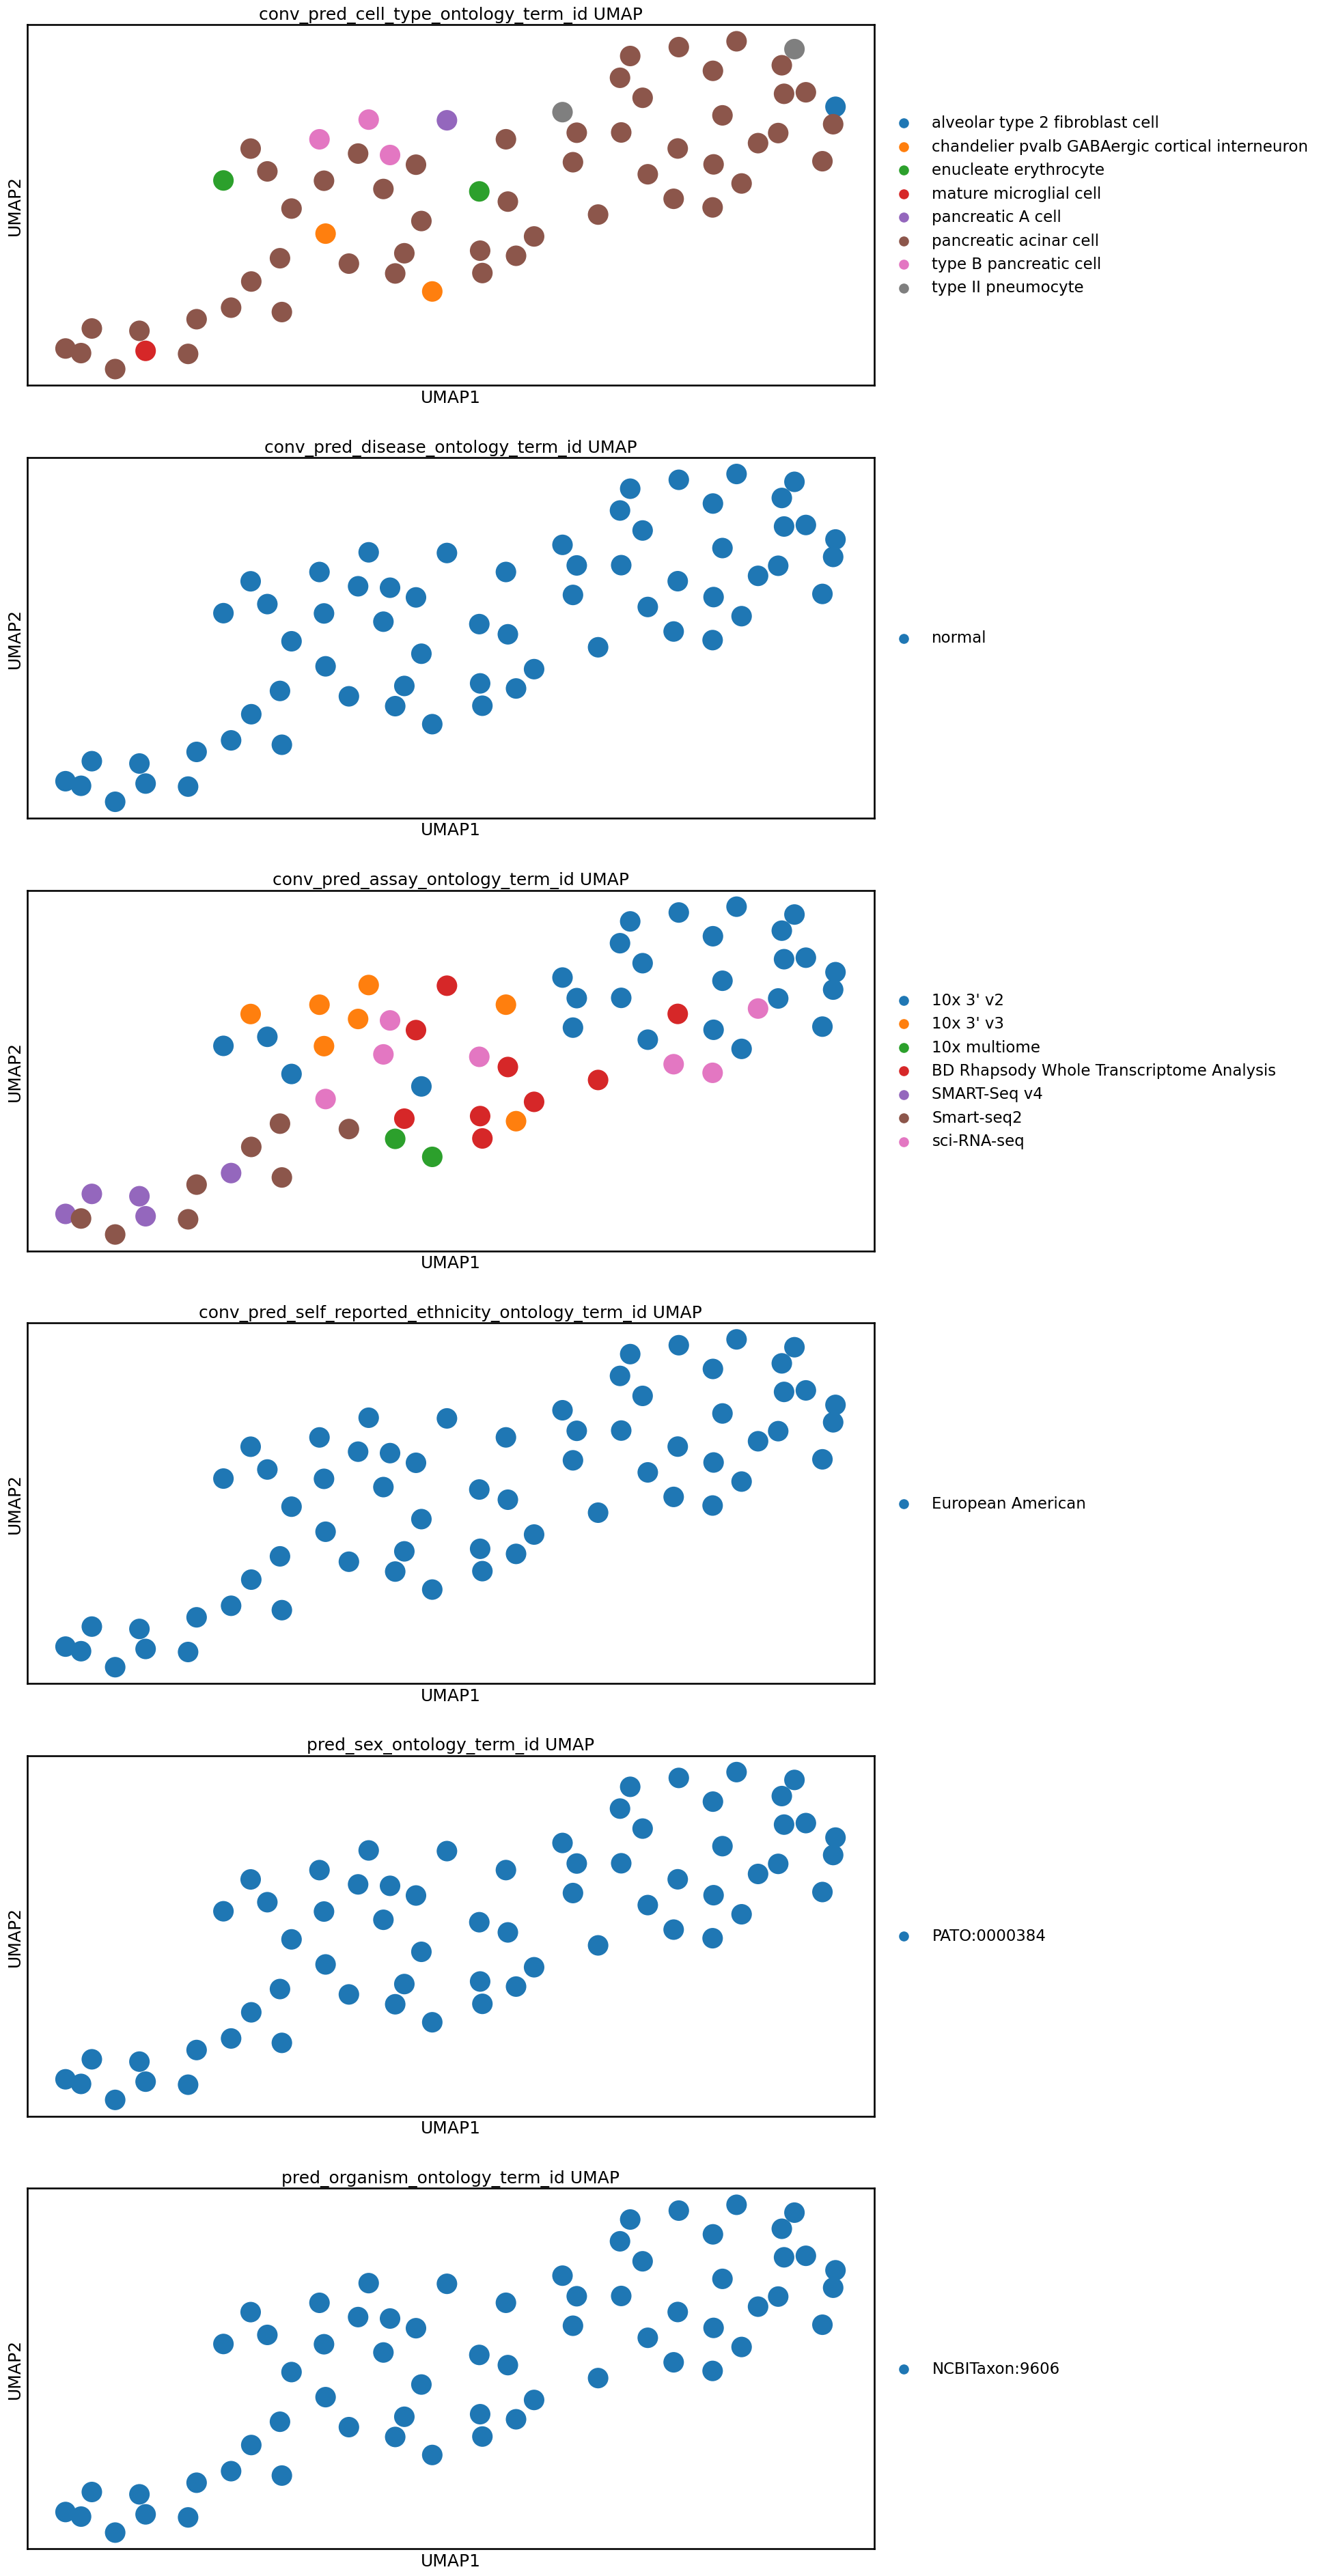

couldn't log to tensorboard
couldn't log to wandb


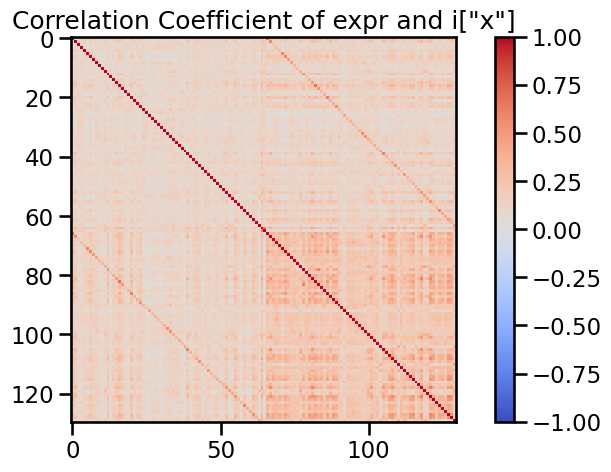

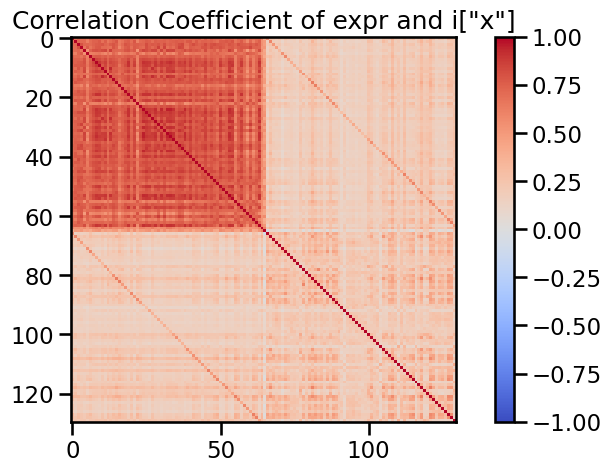

In [10]:
embed_adata, metrics = embedder(adata.copy())

In [11]:
bm = Benchmarker(
    embed_adata,
    batch_key="tech",
    label_key="celltype",
    embedding_obsm_keys=["X_pca", "scprint"],
    n_jobs=6,
)
bm.benchmark()

Metrics:   0%|          | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]2024-04-15 10:56:47,641:INFO - isolated labels: no more than 4 batches per label
2024-04-15 10:56:47,724:INFO - Unable to initialize backend 'cuda': 
2024-04-15 10:56:47,726:INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-04-15 10:56:47,731:INFO - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2024-04-15 10:56:47,732:WARNING - An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.

Metrics:  60%|██████    | 6/10 [00:50<00:25,  6.26s/it, Batch correction: kbet_per_label]/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.

INFO     t_cell consists of a single batch or is too small. Skip.                                                  



Metrics:  70%|███████   | 7/10 [01:04<00:26,  8.97s/it, Batch correction: graph_connectivity]/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)

Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Metrics:   0%|          | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]2024-04-15 10:57:53,558:INFO - isolated labels: no more than 4 batches per label

Metrics:  60%|██████    | 6/10 [04:08<01:41, 25.33s/it, Batch correction: kbet_per_label]/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.v

INFO     t_cell consists of a single batch or is too small. Skip.                                                  



Metrics:  70%|███████   | 7/10 [04:24<01:06, 22.27s/it, Batch correction: graph_connectivity]/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
Metrics:  70%|███████   | 7/10 [04:24<01:06, 22.27s/it, Batch correction: graph_connectivity]/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)

Embeddings: 100%|██████ | 9/10 [04:26<00:11, 11.89s/it, Batch correction: pcr_comparison]██████████| 2/2 [05:31<00:00, 183.62s/it]██████████| 2/2 [05:31<00:00, 165.97s/it]

                                                                                         

In [12]:
df = bm.get_results(min_max_scale=False)

In [13]:
metrics.update(df.T.to_dict()['scprint'])

In [ ]:
grn_inferer = GRNfer(model, adata,
    how="most var across",
    preprocess="softmax",
    head_agg='class',
    cell_agg="mean",
    filtration="none",
    forward_mode="none",
    max_cells=64,
    #k=
    #genes=
    #known_grn
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 7586


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

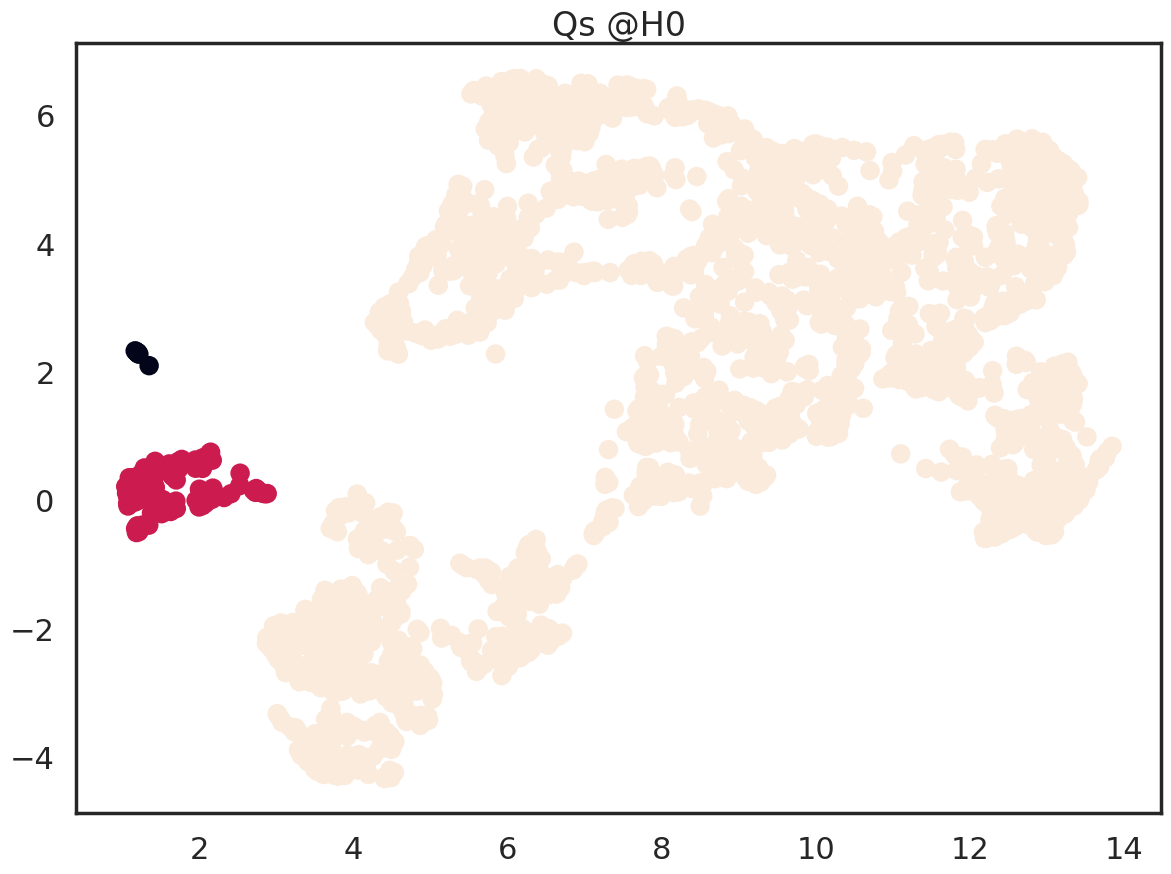

KeyboardInterrupt: 

In [ ]:
grn = grn_inferer(layer=list(range(model.nlayers))[:])

In [ ]:
BenGRN(grn).scprint_benchmark()

In [ ]:
varnames = set(gt.iloc[:, :2].values.flatten())
intersection = varnames & set(curr_genes)

loc = np.isin(curr_genes, np.array(list(intersection)))
curr_genes = np.array(curr_genes)[loc].tolist()
len(curr_genes)

In [ ]:
sadj = adj[:, loc, :][loc, :, :]

da = np.zeros((len(curr_genes), len(curr_genes)), dtype=np.float)
for i, j in gt.iloc[:,:2].values:
    if i in curr_genes and j in curr_genes:
        da[curr_genes.index(i), curr_genes.index(j)] = 1
print("true elem", da.sum()), print("n elem", da.shape[0]**2)

/tmp/ipykernel_664688/1899844792.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros((len(curr_genes), len(curr_genes)), dtype=np.float)


true elem 6331.0
n elem 4426816


(None, None)

In [ ]:
da = da.flatten()
sadj = sadj.reshape(-1, adj.shape[-1])


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(sadj, da, random_state=0, train_size=1_000_000)

clf = LogisticRegression(penalty="l1", C=1, solver="liblinear", class_weight={1:200,0:1}, max_iter=4_000, n_jobs=8)
clf.fit(X_train, y_train)
print("coef", clf.coef_)

pred = clf.predict(X_test)
print("precision", (pred[y_test==1]==1).sum()/(pred==1) .sum())
print("random precision", y_test.sum()/len(y_test))
print("recall", (pred[y_test==1]==1).sum()/y_test.sum())
print("random recall", pred.sum()/len(pred))
print("predicted true", pred.sum())
print("number of true", y_test.sum())
PrecisionRecallDisplay.from_estimator(clf, X_test, y_test, plot_chance_level=True)
plt.show()